<h2>Importing Libraries and Modules</h2>

In [0]:
# !pip install geopy
# !pip install scikit-learn==0.22.1 --user
# !pip install imblearn --user


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np

from geopy.distance import great_circle
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<h2>Loading the Datasets</h2>

In [0]:
# ## Loading the Datasets
# train = pd.read_csv('../data/train.csv')
# test = pd.read_csv('../data/test.csv')

## Loading the Datasets
train = pd.read_csv('drive/My Drive/ML/data/weka_processed/train_pro.csv')
test = pd.read_csv('drive/My Drive/ML/data/test.csv')


<h2>Basic Intuition on the Data</h2>

In [6]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834,56,0,64,'11/1/2019 0:20','11/1/2019 0:34',6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791,47,0,134,'11/1/2019 0:56','11/1/2019 1:09',6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087,80,0,61,'11/1/2019 1:08','11/1/2019 1:26',6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598,271,15.6638,68,'11/1/2019 2:27','11/1/2019 2:37',6.92570,79.8895,6.92748,79.8971,82.3,correct
4,189128020,?,?,?,?,?,'11/1/2019 3:34','11/1/2019 3:51',6.87441,79.8615,6.84478,79.9290,358.39,correct


In [7]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     15327 non-null  int64  
 1   additional_fare            15327 non-null  object 
 2   duration                   15327 non-null  object 
 3   meter_waiting              15327 non-null  object 
 4   meter_waiting_fare         15327 non-null  object 
 5   meter_waiting_till_pickup  15327 non-null  object 
 6   pickup_time                15327 non-null  object 
 7   drop_time                  15327 non-null  object 
 8   pick_lat                   15327 non-null  float64
 9   pick_lon                   15327 non-null  float64
 10  drop_lat                   15327 non-null  float64
 11  drop_lon                   15327 non-null  float64
 12  fare                       15327 non-null  object 
 13  label                      15327 non-null  obj

In [9]:
train.shape

(15327, 14)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     8576 non-null   int64  
 1   additional_fare            8576 non-null   float64
 2   duration                   8576 non-null   int64  
 3   meter_waiting              8576 non-null   int64  
 4   meter_waiting_fare         8576 non-null   float64
 5   meter_waiting_till_pickup  8576 non-null   int64  
 6   pickup_time                8576 non-null   object 
 7   drop_time                  8576 non-null   object 
 8   pick_lat                   8576 non-null   float64
 9   pick_lon                   8576 non-null   float64
 10  drop_lat                   8576 non-null   float64
 11  drop_lon                   8576 non-null   float64
 12  fare                       8576 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage:

In [11]:
test.shape

(8576, 13)

<h2>Cleaning the Data</h2>

In [0]:
## cleaning weka added unnecessary values

train = train.replace({'?': np.nan})


In [0]:
## converting label values into 0,1 instead of correct, incorrect

train.label = train.label.map(dict(correct=1, incorrect=0))

In [14]:
## check for missing values in the dataset

# train.isna().head()
train.isna().sum()

tripid                         0
additional_fare              196
duration                     196
meter_waiting                196
meter_waiting_fare           196
meter_waiting_till_pickup    196
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         133
label                          0
dtype: int64

In [15]:
test.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
dtype: int64

In [0]:
## fill missing values by mean of the column

# train.fillna(train.mean(), inplace=True)

# imputer = IterativeImputer(max_iter=10, random_state=42)
# imputer.fit(train.iloc[:,[1,2,3,4,5,12]])
# train.iloc[:,[1,2,3,4,5,12]] = imputer.transform(train.iloc[:,[1,2,3,4,5,12]])


imputer = KNNImputer(n_neighbors=5, weights='uniform')
train.iloc[:,[1,2,3,4,5,12]] = imputer.fit_transform(train.iloc[:,[1,2,3,4,5,12]])


In [17]:
train.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

<h2>Basic Feature Engineering</h2>

In [0]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)


<h2>Advanced Feature Engineering</h2>

In [0]:
## new feature columns
trip_fare = []
trip_duration = []
trip_distance = []

distance_to_duration = []
fare_to_duration = []
fare_to_distance = []
waiting_fare_to_waiting_duration = []

duration_from_time = []
duration_error = []


In [0]:
## iterate through each row in the dataset
for row in dataset.itertuples():
    fare = float(row.fare)
    additional_fare = float(row.additional_fare)
    meter_waiting_fare = float(row.meter_waiting_fare)
    
    meter_waiting = row.meter_waiting
    meter_waiting_till_pickup = row.meter_waiting_till_pickup
    duration = row.duration
    
    pick_lat = row.pick_lat
    pick_lon = row.pick_lon
    drop_lat = row.drop_lat
    drop_lon = row.drop_lon
    
    pickup_time = row.pickup_time.replace('\'', '')
    drop_time = row.drop_time.replace('\'', '')
    pickup_time = pickup_time.split('/')
    drop_time = drop_time.split('/')
    
    # total fare for the trip
    cur_trip_fare = fare - (additional_fare + meter_waiting_fare)
    trip_fare.append(cur_trip_fare)
    
    # trip duration
    cur_trip_duration = duration - meter_waiting - meter_waiting_till_pickup
    trip_duration.append(cur_trip_duration)
    
    # trip distance
    cur_trip_distance = float(great_circle((drop_lat, drop_lon),(pick_lat, pick_lon)).kilometers)
    trip_distance.append(cur_trip_distance)
    
    # trip distance to duration
    try:
        cur_dist_to_dur = cur_trip_distance / cur_trip_duration
    except ZeroDivisionError:
        cur_dist_to_dur  = 0
    distance_to_duration.append(cur_dist_to_dur)
    
    # trip fare to trip duration
    try:
        cur_fare_to_duration = cur_trip_fare / cur_trip_duration
    except ZeroDivisionError:
        cur_fare_to_duration  = 0
    fare_to_duration.append(cur_fare_to_duration)
    
    # trip fare to trip distance
    try:
        cur_fare_to_distance = cur_trip_fare / cur_trip_distance
    except ZeroDivisionError:
        cur_fare_to_distance  = 0
    fare_to_distance.append(cur_fare_to_distance)
    
    # trip waiting fare to waiting duration
    try:
        cur_waiting_fare_to_waiting_dur = meter_waiting_fare / meter_waiting
    except ZeroDivisionError:
        cur_waiting_fare_to_waiting_dur  = 0
    waiting_fare_to_waiting_duration.append(cur_waiting_fare_to_waiting_dur)
    
    # time duration
    # pickup time
    month, day, y_hm = int(pickup_time[0]), int(pickup_time[1]), pickup_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    pickup_time = datetime.datetime(year, month, day, hour, minute)
    
    # drop time
    month, day, y_hm = int(drop_time[0]), int(drop_time[1]), drop_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    drop_time = datetime.datetime(year, month, day, hour, minute)
    
    # duration
    cur_duration_from_time = (drop_time - pickup_time).seconds
    duration_from_time.append(cur_duration_from_time)
    duration_error.append(cur_duration_from_time - duration)


In [0]:
## append new columns to dataset
dataset['trip_fare'] = trip_fare
dataset['trip_duration'] = trip_duration
dataset['trip_distance'] = trip_distance
dataset['distance_to_duration'] = distance_to_duration
dataset['fare_to_duration'] = fare_to_duration
dataset['fare_to_distance'] = fare_to_distance
dataset['waiting_fare_to_waiting_duration'] = waiting_fare_to_waiting_duration
dataset['duration_from_time'] = duration_from_time
dataset['duration_error'] = duration_error


<h2>Feature Preprocessing</h2>

In [0]:
## Scaling values into 0-1 range

scaler = MinMaxScaler(feature_range=(0,1))
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',
    'fare',
    'trip_fare',
    'trip_duration',
    'trip_distance',
    'distance_to_duration',
    'fare_to_duration',
    'fare_to_distance',
    'waiting_fare_to_waiting_duration', 
    'duration_from_time',
    'duration_error'
]

dataset[features] = scaler.fit_transform(dataset[features])


In [0]:
## Split into training and testing again

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['label'], axis=1, inplace=True)

train['label'] = train['label'].astype(int)


In [0]:
## Drop unnecessary columns
labels_to_drop = [
    'tripid',
#     'pick_lat',
#     'pick_lon',
#     'drop_lat',
#     'drop_lon',
    'pickup_time',
    'drop_time'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


<h2>Feature Importance</h2>

In [120]:
y = train['label']
X = train.drop(labels=['label'], axis=1)

# apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(30, 'Score'))  #print 10 best features


                               Specs      Score
3                 meter_waiting_fare  45.763162
2                      meter_waiting  41.708268
17                duration_from_time  26.766455
9                               fare  16.321160
1                           duration  15.022474
16  waiting_fare_to_waiting_duration   9.070288
6                           pick_lon   7.465128
10                         trip_fare   6.433426
0                    additional_fare   1.522073
15                  fare_to_distance   1.288787
4          meter_waiting_till_pickup   0.240755
5                           pick_lat   0.161323
18                    duration_error   0.010059
7                           drop_lat   0.006369
12                     trip_distance   0.003396
8                           drop_lon   0.001578
13              distance_to_duration   0.001346
14                  fare_to_duration   0.000332
11                     trip_duration   0.000002


In [0]:
## Drop less important columns
labels_to_drop = [
    'trip_distance',
    'fare_to_duration',
    'trip_duration',
    'distance_to_duration',
    'duration_error',
    'meter_waiting_till_pickup',
    'additional_fare'
]

# train.drop(labels=labels_to_drop, axis=1, inplace=True)


<h2>Training and Testing Different Algorithms</h2>

In [0]:
## Seperate train features and label

y_train = train['label']
X_train = train.drop(labels='label', axis=1)

In [0]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=False)


In [30]:
## Test different algorithms
random_state = 42

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier, X_train, y=y_train, scoring="f1", cv=kfold, n_jobs=4)
    )

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

cv_res


,CrossValMeans,CrossValerrors,Algorithm
0,0.952939,0.000425,SVC
1,0.959919,0.003563,DecisionTree
2,0.958353,0.004320,AdaBoost
3,0.975611,0.002098,RandomForest
4,0.976022,0.001516,ExtraTrees
5,0.974240,0.001238,GradientBoosting
6,0.963838,0.000780,MultipleLayerPerceptron
7,0.961870,0.001645,KNeighboors
8,0.952828,0.000505,LogisticRegression
9,0.954504,0.000570,LinearDiscriminantAnalysis


<h2>Handle Class Imbalancy</h2>
<h3>Cluster Majority Class into Distinct Classes</h3>

In [0]:
## Seperate into training and testing
y = train['label']
X = train.drop(labels='label', axis=1)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['label'] = y_train


In [125]:
unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
y_train_dict_value_count

{0: 1124, 1: 11137}

In [126]:
print(11137/1124)


9.908362989323843


In [0]:
## seperate the majority and minority classes
train_cls_1 = X_train[X_train['label']==1]
train_cls_1 = train_cls_1.drop(labels='label', axis=1)

train_cls_0 = X_train[X_train['label']==0]


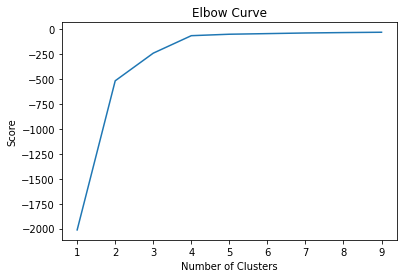

In [128]:
# clustering for majority class

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
scores = [kmeans[i].fit(train_cls_1).score(train_cls_1) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [0]:
kmeans = KMeans(n_clusters=4, init ='k-means++')
pred_cls_1 = kmeans.fit_predict(train_cls_1)

train_cls_1['cluster'] = pred_cls_1

train_cls_1['label'] = [1] * train_cls_1.shape[0]


In [130]:
unique, count = np.unique(pred_cls_1, return_counts=True)
pred_cls_1_value_count = {k:v for (k,v) in zip(unique, count)}
pred_cls_1_value_count


{0: 5364, 1: 4480, 2: 580, 3: 713}

In [0]:
## create multiple dataframes

## cluster 0
temp = train_cls_1[train_cls_1['cluster']==0].drop(labels='cluster', axis=1)
train_df_0 = pd.concat(objs=[temp, train_cls_0], axis=0)
train_df_0 = train_df_0.sample(frac=1).reset_index(drop=True)

## cluster 1
temp = train_cls_1[train_cls_1['cluster']==1].drop(labels='cluster', axis=1)
train_df_1 = pd.concat(objs=[temp, train_cls_0], axis=0)
train_df_1 = train_df_1.sample(frac=1).reset_index(drop=True)

## cluster 2
temp = train_cls_1[train_cls_1['cluster']==2].drop(labels='cluster', axis=1)
train_df_2 = pd.concat(objs=[temp, train_cls_0], axis=0)
train_df_2 = train_df_2.sample(frac=1).reset_index(drop=True)

## cluster 3
temp = train_cls_1[train_cls_1['cluster']==3].drop(labels='cluster', axis=1)
train_df_3 = pd.concat(objs=[temp, train_cls_0], axis=0)
train_df_3 = train_df_3.sample(frac=1).reset_index(drop=True)


<h3>Train Multiple Models for Each {Class, Minority Class} Pair</h3>

In [0]:
## model 1 (for cluster 0)
model1 = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=900
)

model1.fit(train_df_0.drop(labels='label', axis=1), train_df_0['label'])
pred1 = model1.predict_proba(train_df_0.drop(labels='label', axis=1))
# print("Accuracy Model 1: ", accuracy_score(train_df_0['label'], pred1), "%")


## model 2 (for cluster 1)
model2 = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=900
)

model2.fit(train_df_1.drop(labels='label', axis=1), train_df_1['label'])
pred2 = model2.predict_proba(train_df_1.drop(labels='label', axis=1))
# print("Accuracy Model 2: ", accuracy_score(train_df_1['label'], pred2), "%")


## model 3 (for cluster 2)
model3 = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=900
)

model3.fit(train_df_2.drop(labels='label', axis=1), train_df_2['label'])
pred3 = model3.predict_proba(train_df_2.drop(labels='label', axis=1))
# print("Accuracy Model 3: ", accuracy_score(train_df_2['label'], pred3), "%")


## model 4 (for cluster 3)
model4 = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=900
)

model4.fit(train_df_3.drop(labels='label', axis=1), train_df_3['label'])
pred4 = model4.predict_proba(train_df_3.drop(labels='label', axis=1))
# print("Accuracy Model 4: ", accuracy_score(train_df_3['label'], pred4), "%")


<h3>Evaluate On Testing Set</h3>

In [0]:
# def comb_predict(pred1, pred2, pred3, pred4):
#     pred_tot = pred1 + pred2 + pred3 + pred4
#     # return round(pred_tot / 4)              # eval acc: 0.0906

#     if pred_tot>0:                            # eval acc: 0.9595
#         return 1
#     return 0


In [0]:
pred1 = model1.predict_proba(X_eval)
pred1_list = []
for pred in pred1:
    pred1_list.append(pred[0])

pred2 = model2.predict_proba(X_eval)
pred2_list = []
for pred in pred2:
    pred2_list.append(pred[0])

pred3 = model3.predict_proba(X_eval)
pred3_list = []
for pred in pred3:
    pred3_list.append(pred[0])

pred4 = model4.predict_proba(X_eval)
pred4_list = []
for pred in pred4:
    pred4_list.append(pred[0])


# ## combined prediction
# pred_eval = []
# for i in range(len(y_eval)):
#     pred_eval.append( comb_predict(pred1[i], pred2[i], pred3[i], pred4[i]) )

# print("Testing Accuracy: ", accuracy_score(y_eval, pred_eval), "%")


In [160]:
## Train meta learner
pred_df = pd.DataFrame({'pred1': pred1_list, 'pred2': pred2_list, 'pred3': pred3_list, 'pred4': pred4_list})

model_meta = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=900
)

model_meta.fit(pred_df, y_eval)

pred_meta = model_meta.predict(pred_df)
print("Testing Accuracy: ", accuracy_score(y_eval, pred_meta), "%")


Testing Accuracy:  0.9771689497716894 %


<h2>Predicting and Preparing the Submission</h2>

In [0]:
trip_ids = test.tripid

labels_to_drop = [
    'tripid',
#     'pick_lat',
#     'pick_lon',
#     'drop_lat',
#     'drop_lon',
    'pickup_time',
    'drop_time',
#     'trip_distance',
#     'fare_to_duration',
#     'trip_duration',
#     'distance_to_duration',
#     'duration_error',
#     'meter_waiting_till_pickup',
#     'additional_fare'
]

test = test.drop(labels=labels_to_drop, axis=1)


In [0]:
pred1 = model1.predict_proba(test)
pred1_list = []
for pred in pred1:
    pred1_list.append(pred[0])

pred2 = model2.predict_proba(test)
pred2_list = []
for pred in pred2:
    pred2_list.append(pred[0])

pred3 = model3.predict_proba(test)
pred3_list = []
for pred in pred3:
    pred3_list.append(pred[0])

pred4 = model4.predict_proba(test)
pred4_list = []
for pred in pred4:
    pred4_list.append(pred[0])

pred_df = pd.DataFrame({'pred1': pred1_list, 'pred2': pred2_list, 'pred3': pred3_list, 'pred4': pred4_list})


predictions = model_meta.predict(pred_df)


In [163]:
# output = pd.DataFrame({'tripid': trip_ids, 'prediction': predictions})
# output.to_csv('../submissions/160253h_submission_23.csv', index=False)

output = pd.DataFrame({'tripid': trip_ids, 'prediction': predictions})
output.to_csv('160253h_submission_23.csv', index=False)

!cp '160253h_submission_23.csv' "drive/My Drive/ML/submissions/"

print('Completed!')


Completed!


model training.

KNNImputer to impute missing values.

with cross validation (to tune hiper-parameters).

with feature engineering (added 9 new features).

datetime columns have dropped (new features added).

Separate majority class into splits and train multiple models.

[model: Multiple Random Forest Classifiers]

score: 0.97608